# Approximate Inference in Bayesian Deep Learning: Getting Started in Pytorch

In this colab we will walk you through downloading the data, running your method and generating a submission for our NeurIPS 2021 competition. In this colab we use the Pytorch framework. For Jax see [this notebook](https://colab.research.google.com/drive/1SJ6waN8DOfby6qW9WWgJ0VLyaNzauhYD?usp=sharing).

Useful references:
- [Competition website](https://izmailovpavel.github.io/neurips_bdl_competition/)
- [Efficient implementation of several baselines in JAX](https://github.com/google-research/google-research/tree/master/bnn_hmc)
- [Submission platform](https://competitions.codalab.org/competitions/33647)


## Setting up colab

Colab provides an easy-to-use environment for working on the competition with access to free computational resources. However, you should also be able to run this notebook locally after installing the required dependencies. If you use colab, please select a `GPU` runtime type.

## Preparing the data


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

print(os.getcwd())
os.chdir("/content/drive/MyDrive/neurips_bdl_sirius2021")
print(os.getcwd())

/content
/content/drive/MyDrive/neurips_bdl_sirius2021


In [ ]:
import sys
import math
import matplotlib
import numpy as np
import copy

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from matplotlib import pyplot as plt

sys.path.append("neurips_bdl_starter_kit")
import pytorch_models as p_models

We provide the datasets used in this competition in a public Google Cloud Storage bucket in the `.csv` format. Here we download the data:

You can also download the data to your computer by clicking these links:
- [CIFAR-10 train features](https://storage.googleapis.com/neurips2021_bdl_competition/cifar10_train_x.csv)
- [CIFAR-10 train labels](https://storage.googleapis.com/neurips2021_bdl_competition/cifar10_train_y.csv)
- [CIFAR-10 test features](https://storage.googleapis.com/neurips2021_bdl_competition/cifar10_test_x.csv)
- [CIFAR-10 test labels](https://storage.googleapis.com/neurips2021_bdl_competition/cifar10_test_y.csv)

In [ ]:
#!gsutil -m cp -r gs://neurips2021_bdl_competition/cifar10_*.csv .

We can now read the data and convert it into numpy arrays. This cell may take several minutes to run.

In [ ]:
def safe_load_numpy(name):
  name_npy = name + ".npy"
  name_csv = name + ".csv"
  if os.path.exists(name_npy):
    return np.load(name_npy)
  else:
    if not os.path.exists(name_csv):
      os.system(f"gsutil -m cp -r gs://neurips2021_bdl_competition/{name}.csv .")
    d = np.loadtxt(name_csv)
    np.save(name_npy, d)
    return d

In [ ]:
x_train = safe_load_numpy("cifar10_train_x")
y_train = safe_load_numpy("cifar10_train_y")
x_test = safe_load_numpy("cifar10_test_x")
y_test = safe_load_numpy("cifar10_test_y")

In [ ]:
x_train = x_train.reshape((len(x_train), 3, 32, 32))
x_test = x_test.reshape((len(x_test), 3, 32, 32))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


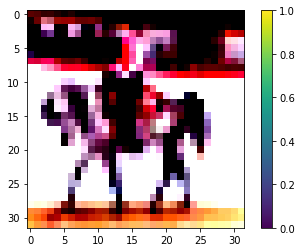

In [ ]:
plt.imshow(x_train[0].reshape(32,32,3))
plt.colorbar()

Finally, we define a `torch.utils.data.TensorDataset` for the train and test datasets.

In [ ]:
trainset = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
testset = TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test))

## Model and losses

We provide the code for all the models used in the competition in the `neurips_bdl_starter_kit/torch_models.py` module. Here, we will load a ResNet-20 model with filter response normalization (FRN) and swish activations. The models are implemented in `pytorch`. 

We also define the cross-entropy likelihood (`log_likelihood_fn`) and Gaussian prior (`log_prior_fn`), and the corresponding posterior log-density (`log_posterior_fn`). The `log_posterior_wgrad_fn` computes the posterior log-density and its gradients with respect to the parameters of the model.

The `evaluate_fn` function computes the accuracy and predictions of the model on a given dataset; we will use this function to generate the predictions for our submission.

In [ ]:
!nvidia-smi

Thu Jul 29 20:45:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
net_fn =  p_models.get_model("resnet20_frn_swish", data_info={"num_classes": 10})
if torch.cuda.is_available():
    print("GPU available!")
    net_fn = net_fn.cuda()

GPU available!


In [ ]:
prior_variance = 5.

def log_likelihood_fn(model_state_dict, batch):
    """Computes the log-likelihood."""
    x, y = batch
    if torch.cuda.is_available():
      x = x.cuda()
      y = y.cuda()
    net_fn.zero_grad()
    for name, param in net_fn.named_parameters():
        param.data = model_state_dict[name]
    logits = net_fn(x)
    num_classes = logits.shape[-1]
    labels = F.one_hot(y.to(torch.int64), num_classes= num_classes)
    softmax_xent = torch.sum(labels * F.log_softmax(logits))

    return softmax_xent


def log_prior_fn(model_state_dict):
    """Computes the Gaussian prior log-density."""
    n_params = sum(p.numel() for p in model_state_dict.values()) 
    exp_term = sum((-p**2 / (2 * prior_variance)).sum() for p in model_state_dict.values() )
    norm_constant = -0.5 * n_params * math.log((2 * math.pi * prior_variance))
    return exp_term + norm_constant


def log_posterior_fn(model_state_dict, batch):
    log_lik = log_likelihood_fn(model_state_dict, batch)
    log_prior = log_prior_fn(model_state_dict)
    return log_lik + log_prior


def get_accuracy_fn(batch, model_state_dict):
    x, y = batch
    if torch.cuda.is_available():
      x = x.cuda()
      y = y.cuda()
    # get logits 
    net_fn.eval()
    with torch.no_grad():
      for name, param in net_fn.named_parameters():
          param.data = model_state_dict[name]
      logits = net_fn(x)
    net_fn.train()
    # get log probs 
    log_probs = F.log_softmax(logits, dim=1)
    # get preds 
    probs = torch.exp(log_probs)
    preds = torch.argmax(logits, dim=1)
    accuracy = (preds == y).float().mean()
    return accuracy, probs


def evaluate_fn(data_loader, model_state_dict):
    sum_accuracy = 0
    all_probs = []
    for x, y in data_loader:       
        batch_accuracy, batch_probs = get_accuracy_fn((x, y), model_state_dict)
        sum_accuracy += batch_accuracy.item()
        all_probs.append(batch_probs)
    all_probs = torch.cat(all_probs, dim=0)
    return sum_accuracy / len(data_loader), all_probs

## Optimization and training 

In this colab we train an approximate maximum-a-posteriori (MAP) solution as our submission for simplicity. You can find efficient implementations of more advanced baselines in jax [here](https://github.com/google-research/google-research/tree/master/bnn_hmc).

We use SGD with momentum. You can adjust the hyper-parameters or switch to a different optimizer by changing the code below.

We run training for 5 epochs, which can take several minutes to complete. Note that in order to achieve good results you need to run the method substantially longer and tune the hyper-parameters.

In [ ]:
batch_size = 100
test_batch_size = 100
num_epochs = 0
momentum_decay = 0.9
lr = 0.001

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testset, batch_size=test_batch_size, shuffle=False)

In [ ]:
epoch_steps = len(train_loader)

optimizer = optim.SGD(net_fn.parameters(), lr=lr, momentum=momentum_decay)

for epoch in range(num_epochs):
  running_loss = 0.0
  total_loss = 0.0
  for i, data in enumerate(train_loader):
    optimizer.zero_grad()
    model_state_dict = copy.deepcopy(net_fn.state_dict())
    loss = - log_posterior_fn(model_state_dict, data)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    total_loss += loss.item()
    if i % 100 == 99:    # print every 100 mini-batches
      print('[%d, %5d] loss: %.3f' %
            (epoch + 1, i + 1, running_loss / 100))
      running_loss = 0.0
  model_state_dict = copy.deepcopy(net_fn.state_dict())
  test_acc, all_test_probs = evaluate_fn(test_loader, model_state_dict)
  print("Epoch {}".format(epoch))
  print("\tAverage loss: {}".format(total_loss / epoch_steps))
  print("\tTest accuracy: {}".format(test_acc))

In [ ]:
# torch.save(net_fn.state_dict(), "10_epoch.pth")

net_fn.load_state_dict(torch.load("10_epoch.pth"))
net_fn.eval()

model_state_dict = copy.deepcopy(net_fn.state_dict())
test_acc, all_test_probs = evaluate_fn(test_loader, model_state_dict)
print("\tTest accuracy: {}".format(test_acc))

In [ ]:
import swag

T = 200
batch_size = 100

teta, teta_sqr, D = swag.train_SWAG(net_fn, log_posterior_fn, trainset, T, batch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


In [ ]:
import averaging

S = 10

diag = abs(teta_sqr) #???
all_test_probs = averaging.average_models(net_fn, test_loader, teta, diag, D, S)

In [ ]:
all_test_probs = np.asarray(all_test_probs.cpu())

## Evaluating metrics

The starter kit comes with a script that can compute the agreement and total variation distance metrics used in the competition.

In [ ]:
import metrics

We can load the HMC reference predictions from the starter kit as well.

In [ ]:
with open('data/cifar10/probs.csv', 'r') as fp:
  reference = np.loadtxt(fp)

Now we can compute the metrics!

In [ ]:
metrics.agreement(all_test_probs, reference)

0.5188

In [ ]:
metrics.total_variation_distance(all_test_probs, reference)

0.5215532113453087

## Preparing the submission

Once you run the code above, `all_test_probs` should contain an array of size `10000 x 10` where the rows correspond to test datapoints and columns correspond to classes.

In [ ]:
all_test_probs.shape

(10000, 10)

Now, we need to save the array as `cifar10_probs.csv` and create a zip archive with this file.

In [ ]:
np.savetxt("cifar10_probs.csv", all_test_probs)

!zip submission.zip cifar10_probs.csv

  adding: cifar10_probs.csv (deflated 56%)


Finally, you can download the submission by running the code below. If the download doesn't start, check that your browser did not block it automatically.

In [ ]:
from google.colab import files
files.download('submission.zip') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Now you can head over to the [submission system](https://competitions.codalab.org/competitions/33512?secret_key=10f23c1f-9c86-4a7a-8406-d85b0a0713f2#participate) and upload your submission. Good luck :)